In [1]:
import pandas as pd
from scipy import stats
from scipy.spatial import distance
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings


from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_squared_error

# Different Scalers for transcripts and methylations
TPMscaler = StandardScaler()
Methscaler = StandardScaler()

/home/sbl/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [59]:
MethTCGA = pd.read_pickle('/home/sbl/Documents/TCGA/Pan Cancer/pancan_methylation.pkl')
MethTCGA = MethTCGA.T


TCGAtpm = pd.read_pickle('TCGA.Kallisto.TPM.pkl')
TCGAtpm = TCGAtpm.set_index('sample')

In [5]:
CommPatients = MethTCGA.columns.intersection(TCGAtpm.columns)
MethTCGA = MethTCGA[CommPatients]
TCGAtpm = TCGAtpm[CommPatients]

TCGAtpm = TCGAtpm.astype('float32')
MethTCGA = MethTCGA.astype('float32')

TCGAtpm = (2 ** TCGAtpm) - 0.001

MethTCGA = MethTCGA.T
TCGAtpm = TCGAtpm.T

In [37]:
# Methylation Annotations
Meth450Annotations = pd.read_table('HM450.hg38.manifest.gencode.v22.tsv.gz', compression='gzip', low_memory=False, sep='\t')
Meth450Annotations = Meth450Annotations.dropna(subset='transcriptIDs')
Meth450Annotations = Meth450Annotations.drop_duplicates(subset='probeID', keep='first')
Meth450Annotations = Meth450Annotations.set_index('probeID')

In [40]:
# Selecting Common CPGS in TCGA and Annotation files
CommonCPGs = list(Meth450Annotations.index.intersection(MethTCGA.columns))
Meth450Annotations = Meth450Annotations.loc[CommonCPGs]

### Selecting 1000 Random CPGs for Prediction 
#### Only protein coding 

In [461]:
# Meth450Annotations.loc[:,'TranscriptsNo'] = Meth450Annotations['transcriptIDs'].apply(lambda x: len(x.split(';')))
# Meth450AnnotationsDummy = Meth450Annotations[(Meth450Annotations['TranscriptsNo'] > 3 ) & (Meth450Annotations['TranscriptsNo'] < 5 )]

In [8]:
# Selecting Protein Coding Genes
ProteinCodCpgsAnnotations = Meth450Annotations[Meth450Annotations['transcriptTypes'].str.contains('protein_coding', case=False)]

In [472]:
# import random
# CPGsRandom = list(random.sample(set(ProteinCodCpgsAnnotations.index), 1000))
# RandomCpgsAnnotations = ProteinCodCpgsAnnotations.loc[CPGsRandom]

In [9]:
ProteinCodCpgsAnnotations.loc[:, 'transcriptIDs'] = ProteinCodCpgsAnnotations['transcriptIDs'].str.split(';')
ProteinCodCpgsAnnotations = ProteinCodCpgsAnnotations.explode('transcriptIDs')

In [10]:
CommTranscripts = TCGAtpm.columns[TCGAtpm.columns.isin(ProteinCodCpgsAnnotations['transcriptIDs'])]
ProteinCodCpgsAnnotations = ProteinCodCpgsAnnotations[ProteinCodCpgsAnnotations['transcriptIDs'].isin(CommTranscripts)]

In [11]:
CpgsGeneDict = ProteinCodCpgsAnnotations['transcriptIDs'].to_dict()
len(CpgsGeneDict)

263497

#### Splitting Based on Cancer Subtype

In [60]:
TCGAphenotype = pd.read_table('TCGA_phenotype_denseDataOnlyDownload.tsv.gz', compression='gzip')
TCGAphenotype = TCGAphenotype.set_index('sample')
TCGAphenotype = TCGAphenotype.loc[CommPatients]

NameError: name 'CommPatients' is not defined

In [13]:
TrainTpmIdx, TempTpmIdx , TrainMethIdx, TempMethIdx = train_test_split(TCGAphenotype.index, TCGAphenotype.index, train_size=0.5, random_state=42, stratify=TCGAphenotype['_primary_disease'])
ValTpmIdx, TestTpmIdx , ValMethIdx, TestMethIdx =  train_test_split(TempTpmIdx, TempMethIdx, train_size=0.5, random_state=42, stratify=TCGAphenotype.loc[TempTpmIdx]['_primary_disease'])


TrainTpm = TCGAtpm.loc[TrainTpmIdx]
ValTpm = TCGAtpm.loc[ValTpmIdx]
TestTPM = TCGAtpm.loc[TestTpmIdx]


TrainMeth = MethTCGA.loc[TrainMethIdx]
ValMeth = MethTCGA.loc[ValMethIdx]
TestMeth = MethTCGA.loc[TestMethIdx]

In [14]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None

try:
    from lightgbm import LGBMRegressor
except ImportError:
    LGBMRegressor = None

try:
    from catboost import CatBoostRegressor
except ImportError:
    CatBoostRegressor = None


In [16]:
models = []

np.random.seed(42)
# Linear Models
models.append(('LinearRegression', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Ridge 0.01', Ridge(alpha=0.01)))
models.append(('Lasso', Lasso()))
models.append(('Lasso 0.01', Lasso(alpha=0.01)))
models.append(('ElasticNet', ElasticNet()))
models.append(('ElasticNet 0.01', ElasticNet(l1_ratio=0.01)))

# Tree-based Models
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest 1', RandomForestRegressor(n_estimators=1, n_jobs=-1)))
models.append(('RandomForest 2', RandomForestRegressor(n_estimators=2, n_jobs=-1)))
models.append(('RandomForest 3', RandomForestRegressor(n_estimators=3, n_jobs=-1)))
models.append(('ExtraTrees', ExtraTreesRegressor(n_jobs=-1)))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('AdaBoost', AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=10)))

# Support Vector Regressor
models.append(('SVR', SVR()))

# K-Nearest Neighbors
# models.append(('KNeighbors', KNeighborsRegressor()))

# Neural Network
models.append(('MLPRegressor', MLPRegressor(max_iter=500)))

# Conditional Models
if XGBRegressor is not None:
    models.append(('XGBRegressor', XGBRegressor()))
if LGBMRegressor is not None:
    models.append(('LGBMRegressor', LGBMRegressor()))
if CatBoostRegressor is not None:
    models.append(('CatBoostRegressor', CatBoostRegressor(verbose=0)))


In [15]:
models = []

np.random.seed(42)
# Linear Models
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))

# Tree-based Models

In [425]:
# Models = [RandomForestRegressor(random_state=42, n_estimators=1, n_jobs=-1)]

def PredictMethylation(Models, cpgs, Annotations,TrainTpm, TestTpm, TrainMeth, TestMeth):
    ResultList = []
    for model in Models:
        Model = model[1]
        for SelectedCpg in cpgs:

            SelectedTranscripts = len(Annotations.loc[SelectedCpg][['transcriptIDs']])
            if SelectedTranscripts == 1:
                SelectedTranscripts = list(RandomCpgsAnnotations.loc[SelectedCpg][['transcriptIDs']].values)
            else:
                SelectedTranscripts = RandomCpgsAnnotations.loc[SelectedCpg]['transcriptIDs'].values
            Model.fit(TPMscaler.fit_transform(TrainTpm[SelectedTranscripts].fillna(0)), TrainMeth[SelectedCpg].fillna(0))

            predictedMeth = Model.predict(TPMscaler.transform(TestTpm[SelectedTranscripts].fillna(0)))

            resultDict = {'CPG':SelectedCpg, "PearsonR":stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[0], 
                        "Euclidean Distance" : distance.euclidean(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'RMSE': root_mean_squared_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        'MSE': mean_squared_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "MAE": mean_absolute_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "R2" : r2_score(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'P.Val' : stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[1], 
                        'Model':model[0], 
                        }
            ResultList.append(resultDict)
    return pd.DataFrame(ResultList)
        # pd.DataFrame(ResultList).to_csv('RandomCPGSpearson.csv')

In [426]:
MethPredicted = PredictMethylation(models, list(CpgsGeneDict.keys())[:10], ProteinCodCpgsAnnotations, TrainTpm, ValTpm, TrainMeth, ValMeth)

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
ResultList = []
i = 1
for SelectedCpg in list(CpgsGeneDict.keys()):   
    for model in models:        
        Model = model[1]
        SelectedTranscripts = len(ProteinCodCpgsAnnotations.loc[SelectedCpg][['transcriptIDs']])
        if SelectedTranscripts == 1:
            SelectedTranscripts = list(ProteinCodCpgsAnnotations.loc[SelectedCpg][['transcriptIDs']].values)
        else:
            SelectedTranscripts = ProteinCodCpgsAnnotations.loc[SelectedCpg]['transcriptIDs'].values
        Model.fit(TPMscaler.fit_transform(TrainTpm[SelectedTranscripts].fillna(0)), TrainMeth[SelectedCpg].fillna(0))  
        predictedMeth = Model.predict(TPMscaler.transform(ValTpm[SelectedTranscripts].fillna(0))) 
        resultDict = {'CPG':SelectedCpg, "PearsonR":stats.pearsonr(predictedMeth,ValMeth[SelectedCpg].fillna(0))[0], 
                    "Euclidean Distance" : distance.euclidean(predictedMeth,ValMeth[SelectedCpg].fillna(0)), 
                    'RMSE': root_mean_squared_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
                    'MSE': mean_squared_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
                    "MAE": mean_absolute_error(predictedMeth,ValMeth[SelectedCpg].fillna(0)),
                    "R2" : r2_score(predictedMeth,ValMeth[SelectedCpg].fillna(0)), 
                    'P.Val' : stats.pearsonr(predictedMeth,ValMeth[SelectedCpg].fillna(0))[1], 
                    'Model':model[0], 
                    
                    }
        ResultList.append(resultDict)
        pd.DataFrame(ResultList).to_csv('EnsembleModelAllCPGs.csv')
    print(i ,"Out of " ,len(list(CpgsGeneDict.keys())))
    i += 1    

1 Out of  263497
2 Out of  263497
3 Out of  263497
4 Out of  263497
5 Out of  263497
6 Out of  263497
7 Out of  263497
8 Out of  263497
9 Out of  263497
10 Out of  263497
11 Out of  263497
12 Out of  263497
13 Out of  263497
14 Out of  263497
15 Out of  263497
16 Out of  263497
17 Out of  263497
18 Out of  263497
19 Out of  263497
20 Out of  263497
21 Out of  263497
22 Out of  263497
23 Out of  263497
24 Out of  263497
25 Out of  263497
26 Out of  263497
27 Out of  263497
28 Out of  263497
29 Out of  263497
30 Out of  263497
31 Out of  263497
32 Out of  263497
33 Out of  263497
34 Out of  263497
35 Out of  263497
36 Out of  263497
37 Out of  263497
38 Out of  263497
39 Out of  263497
40 Out of  263497
41 Out of  263497
42 Out of  263497
43 Out of  263497
44 Out of  263497
45 Out of  263497
46 Out of  263497
47 Out of  263497
48 Out of  263497
49 Out of  263497
50 Out of  263497
51 Out of  263497
52 Out of  263497
53 Out of  263497
54 Out of  263497
55 Out of  263497
56 Out of  263497
5

<Axes: xlabel='PearsonR', ylabel='Count'>

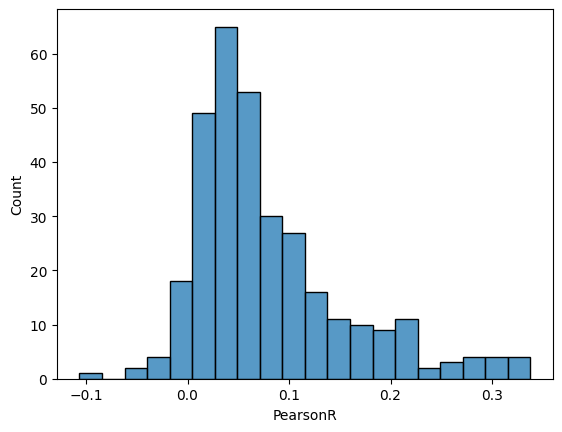

In [5]:
import pandas as pd
import seaborn as sns
df = pd.read_csv("EnsembleAnalysis/Results/EnsembleModel.9000.to.10499.csv")
sns.histplot(df.PearsonR)   

In [69]:
df = pd.read_csv('/home/sbl/Documents/ICI pred/tcga bridge/CibersortDocker/cibersortxOutput/CIBERSORTx_Results.txt', sep='\t')
df.iloc[:,1:].median()

B cells naive                      0.020394
B cells memory                     0.000000
Plasma cells                       0.018103
T cells CD8                        0.094601
T cells CD4 naive                  0.000000
T cells CD4 memory resting         0.035699
T cells CD4 memory activated       0.000000
T cells follicular helper          0.084236
T cells regulatory (Tregs)         0.043662
T cells gamma delta                0.000000
NK cells resting                   0.030289
NK cells activated                 0.000111
Monocytes                          0.012616
Macrophages M0                     0.174900
Macrophages M1                     0.054952
Macrophages M2                     0.146430
Dendritic cells resting            0.000000
Dendritic cells activated          0.000000
Mast cells resting                 0.025937
Mast cells activated               0.000000
Eosinophils                        0.000000
Neutrophils                        0.000000
P-value                         

In [6]:
import pandas as pd

In [81]:
89326 + 50000

139326